In [1]:
# !pip install pyarrow

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

#import xgbtune 

In [3]:
df = pd.read_parquet("../data/dataset.parquet")
df

,date,close,high,low,open,volume,up_down_close_1,volitility_open_7,volitility_pct_change_7_open,high_low_7,...,volume_lag_29,day_of_week,day_of_month,month,year,week_of_year,short_ema_50,long_ema_200,macd_50_200,macd_hist_50_200_9
0,2005-03-10,1.198628,1.211568,1.176660,1.189600,777109200,1,NaN,NaN,0.034908,...,NaN,3,10,3,2005,10,1.198628,1.198628,0.000000,0.000000
1,2005-03-11,1.211869,1.221500,1.197726,1.210064,632830800,1,NaN,NaN,0.023774,...,NaN,4,11,3,2005,10,1.199147,1.198760,0.000388,0.000310
2,2005-03-14,1.213374,1.227518,1.189299,1.219393,605385200,1,NaN,NaN,0.038219,...,NaN,0,14,3,2005,11,1.199705,1.198905,0.000800,0.000578
3,2005-03-15,1.232634,1.238051,1.211267,1.223004,508608800,1,NaN,NaN,0.026784,...,NaN,1,15,3,2005,11,1.200996,1.199241,0.001756,0.001227
4,2005-03-16,1.239254,1.273260,1.227217,1.240157,697813200,1,NaN,NaN,0.046042,...,NaN,2,16,3,2005,11,1.202497,1.199639,0.002858,0.001863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,2025-03-03,238.029999,244.029999,236.110001,241.789993,47184000,0,3.875833,0.014816,7.919998,...,68488300.0,0,3,3,2025,10,238.174593,224.429831,13.744762,-0.135583
5027,2025-03-04,235.929993,240.070007,234.679993,237.710007,53798100,0,4.093936,0.015536,5.390015,...,98070400.0,1,4,3,2025,10,238.086570,224.544261,13.542309,-0.270429
5028,2025-03-05,235.740005,236.550003,229.229996,235.419998,47227600,0,4.471435,0.015638,7.320007,...,64126500.0,2,5,3,2025,10,237.994547,224.655661,13.338886,-0.379081
5029,2025-03-06,235.330002,237.860001,233.160004,234.440002,45170400,1,3.525962,0.013558,4.699997,...,60234800.0,3,6,3,2025,10,237.890056,224.761874,13.128182,-0.471828


In [4]:
# target = "target_close"
# target = "close_percent_change_1"
target = "up_down_close_1"

x = df.drop(columns=[target]).set_index("date")
y = df[["date", target]].set_index("date")
y

,up_down_close_1
date,
2005-03-10,1
2005-03-11,1
2005-03-14,1
2005-03-15,1
2005-03-16,1
...,...
2025-03-03,0
2025-03-04,0
2025-03-05,0


In [5]:
table_info = pd.DataFrame()

# Print columns that are not int, float, bool or category
for col in x.columns:
    dtype = x[col].dtype
    if dtype not in ["int", "float64", "bool", "category"]:
        table_info = pd.concat([table_info, pd.DataFrame({"Column Name": [col], "Data Type": [x[col].dtype]})])

table_info

,Column Name,Data Type
0,crossed_close_bollinger_lower_30_close_event_name,object
0,crossed_close_close_bollinger_upper_30_event_name,object
0,dividends_event_name,object
0,splits_event_name,object


In [6]:
# Convert columns to float if they are not int, float, bool or category. Handle Cannot cast DatetimeArray to dtype float64 (XGBoosted models cannot use strings, but categories as enumerated values)
for col in x.columns:
    dtype = x[col].dtype
    if dtype not in ["int", "float64", "bool", "category"]:
        try:
            x[col] = x[col].astype("float")
        except:
            # drop datetime columns
            x = x.drop(columns=[col])

            print(f"Dropped Column: {col}")

Dropped Column: crossed_close_bollinger_lower_30_close_event_name
Dropped Column: crossed_close_close_bollinger_upper_30_event_name
Dropped Column: dividends_event_name
Dropped Column: splits_event_name


In [7]:
# # Normalizing the features between 0 and 1
# y_scaler = MinMaxScaler()
# y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# x_scaler = MinMaxScaler()
# x = x_scaler.fit_transform(x)

# y

In [8]:
#    All Features   | Target
# +-----------------+---------+
# | x_train         | y_train | <- 85% of the data which is used for training
# |                 |         |
# +-----------------+---------+
# | x_test          | y_test  | <- 15% of the data which is used for testing
# +-----------------+---------+


# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
# x_train

In [9]:
# y_test

In [10]:
x_train

,close,high,low,open,volume,volitility_open_7,volitility_pct_change_7_open,high_low_7,high_close_7,low_close_7,...,volume_lag_29,day_of_week,day_of_month,month,year,week_of_year,short_ema_50,long_ema_200,macd_50_200,macd_hist_50_200_9
date,,,,,,,,,,,,,,,,,,,,,
2005-10-03,1.638296,1.641305,1.615424,1.629869,507553200,0.033972,0.026572,0.025880,0.027986,0.002106,...,387732800.0,0,3,10,2005,40,1.448257,1.284544,0.163713,0.014957
2024-02-01,185.744797,185.834256,182.722947,182.891930,64885400,4.320947,0.008181,3.111309,2.534756,0.576553,...,40714100.0,3,1,2,2024,5,187.393215,178.686840,8.706375,-0.283538
2024-01-10,185.078812,185.287550,182.822355,183.249796,46792900,1.840183,0.014937,2.465195,1.252485,1.212710,...,38415400.0,2,10,1,2024,2,186.641724,177.147657,9.494067,-0.585496
2016-11-18,25.453964,25.564976,25.361456,25.375332,113715600,0.414995,0.019968,0.203520,0.136454,0.067066,...,144944000.0,4,18,11,2016,46,25.626943,24.628337,0.998606,-0.090783
2010-07-22,7.794845,7.824336,7.683197,7.754519,645318800,0.217217,0.043230,0.141139,0.173340,0.032201,...,776356000.0,3,22,7,2010,29,7.643953,6.758043,0.885910,-0.038168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-07-08,1.151080,1.151983,1.127607,1.139645,290735200,0.015926,0.021628,0.024376,0.019561,0.004816,...,525520800.0,4,8,7,2005,27,1.137956,1.171900,-0.033944,0.000236
2010-08-16,7.452378,7.523700,7.421682,7.450572,318430000,0.183428,0.017493,0.102018,0.027381,0.074637,...,615235600.0,0,16,8,2010,33,7.694555,6.915107,0.779448,-0.040935
2021-06-07,123.369713,123.781270,122.321218,123.634283,71057600,0.896475,0.008523,1.460052,0.421369,1.038684,...,66905100.0,0,7,6,2021,23,124.542204,117.324212,7.217993,-0.556541


In [11]:
import numpy

from itertools import count, takewhile
def frange(start, stop, step):
    return takewhile(lambda x: x< stop, count(start, step))

# list(frange(0, 1, 0.1))
numpy.linspace(5, 10, num=6).tolist()

[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [12]:
y_train

,up_down_close_1
date,
2005-10-03,0
2024-02-01,0
2024-01-10,0
2016-11-18,1
2010-07-22,1
...,...
2005-07-08,0
2010-08-16,1
2021-06-07,1


In [13]:
from xgboost import XGBClassifier

# model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=1, colsample_bytree=.3)
# model = xgb.XGBRegressor(n_estimators=150, max_depth=7, eta=0.05, subsample=1, colsample_bytree=.3)
# model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.05, subsample=1, colsampvle_bytree=.3)
model = XGBClassifier(n_estimators=500, max_depth=5, eta=0.05, subsample=0.9, colsample_bytree=0.4)
model.fit(x_train, y_train)



pickle.dump(model, open("../model/xgboost_model.pkl", "wb")) # Save model as Python pickle object
model.save_model("../model/xgboost_model.json")

In [14]:
# print(model.best_params_)
# model


In [15]:
predicted = model.predict(x_test)
y_test["predicted"] = predicted
y_test

,up_down_close_1,predicted
date,,
2020-02-14,0,0
2017-12-26,1,1
2013-06-24,1,1
2019-01-07,1,1
2023-11-10,0,0
...,...,...
2005-12-06,0,1
2009-10-01,1,1
2014-12-09,0,0


In [16]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y_test[target], y_test["predicted"])
print("accuracy:", accuracy)

balanced_accuracy_score = metrics.balanced_accuracy_score(y_test[target], y_test["predicted"])
print("balanced_accuracy_score:", balanced_accuracy_score)

recall = metrics.recall_score(y_test[target], y_test["predicted"])
print("recall:", recall)

precision = metrics.precision_score(y_test[target], y_test["predicted"])
print("precision:", precision)

average_precision = metrics.average_precision_score(y_test[target], y_test["predicted"])
print("average_precision:", average_precision)

f1 = metrics.f1_score(y_test[target], y_test["predicted"])
print("f1:", f1)

# more metrics: https://scikit-learn.org/stable/modules/model_evaluation.html


accuracy: 0.5273088381330685
balanced_accuracy_score: 0.5257909731593942
recall: 0.6062378167641326
precision: 0.5316239316239316
average_precision: 0.5228863608428873
f1: 0.5664845173041895


accuracy: 0.5153922542204568
recall: 0.6316793893129771
precision: 0.5287539936102237
f1: 0.5756521739130435

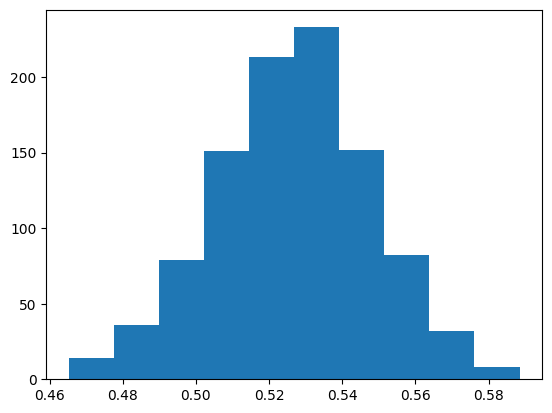

In [17]:
# Confidaence interval
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# configure bootstrap
n_iterations = 1000
n_size = int(len(y_test) * 0.5)
# run bootstrap
stats = list()

for i in range(n_iterations):
    # prepare train and test sets
    test = resample(y_test, n_samples=n_size)
    # calculate accuracy
    accuracy = accuracy_score(test[target], test["predicted"])
    stats.append(accuracy)

# plot scores
plt.hist(stats)
plt.show()

In [18]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test[target], y_test["predicted"]))
# print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.52      0.45      0.48       494
           1       0.53      0.61      0.57       513

    accuracy                           0.53      1007
   macro avg       0.53      0.53      0.52      1007
weighted avg       0.53      0.53      0.52      1007



In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test[target], y_test["predicted"])


array([[220, 274],
       [202, 311]])

In [20]:
# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# indices
# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print(f"{f + 1}. feature {x_train.columns[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature close_bollinger_upper_7 (0.007640949450433254)
2. feature open_rolling_exp_mean_30 (0.006606233771890402)
3. feature low_lag_17 (0.006335550919175148)
4. feature high_bollinger_lower_14 (0.006221953779459)
5. feature low_lag_4 (0.006154690403491259)
6. feature high_bollinger_upper_7 (0.0060321432538330555)
7. feature high_lag_7 (0.005693914834409952)
8. feature open_lag_25 (0.005503853317350149)
9. feature open_lag_13 (0.005281487945467234)
10. feature volume_weighted_average_price_30 (0.0052770026959478855)
11. feature close_rolling_mean_30 (0.005235443357378244)
12. feature high_lag_12 (0.00518821133300662)
13. feature close_bollinger_upper_14 (0.005105459596961737)
14. feature close_rolling_exp_mean_7 (0.00500013493001461)
15. feature high_lag_9 (0.0049620214849710464)
16. feature open_lag_17 (0.0049392227083444595)
17. feature close_rolling_mean_7 (0.00489061139523983)
18. feature close_lag_20 (0.004782489966601133)
19. feature high_bollinger_lower_7 (0.

In [21]:
# Save predicted values
y_test.sort_index().to_parquet("../data/predicted.parquet")